In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

### Hyperparameters initialisation:

In [4]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [5]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [6]:
#we need to set up a few parameters for the high dimensional feature function PHI:
#here phi is assumed to be a radial basis kernel function

#number of rbf centers
num_phi_rbf = 100 #used to be 100

#sigma of the radial basis function
phi_rbf_sigma =5.0 #used to be 1

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 10 

In [7]:
#dimension of the latent variable z that embeds beta
z_dim = 16

In [8]:
# Gives the numbers of betas to learn
num_training_funcs = 2000 

In [9]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
K = 100

In [10]:
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [11]:
# The observation standard deviation for the MCMC
obs_sigma = 0.01 

### Ornstein Uhlenbeck PROCESS - SDE: 
Parameters are the volatility $\sigma>0$, the mean $\mu,$ and $\theta>0.$ . The SDE (Langevin Equation) for a OU process is given by: 
### $ dX_t=\theta(\mu - X_t)dt+\sigma dW_t, $ 
where $W_t$ is a Wiener process.

In [12]:
dt = 0.001

n_steps=1000

In [72]:
#set of indices between 0 and n_steps-1
indices= [i for i in range(n_steps)]
indices_np=np.array(indices)
indices_np.shape

(1000,)

In [14]:
indices_lims=[0,999]

In [15]:
theta=2.0
sigma=1.0
mu=0.0

In [16]:
stationary_variance=sigma**2/(2*theta)
stationary_std=sigma/(np.sqrt(2*theta))
stationary_std

0.5

In [17]:
def generate_OU_dataset():
    
    indices_append=[]
    OU_value_at_K_locations_append=[]

    for fct_id in range(num_training_funcs):  
        
        #for each sampled path, we draw different parameter values for sigma, mu and theta:
        #sigma = np.random.uniform(2.0,6.0)
        #mu = np.random.uniform(0.0, 0.1)     
        #theta = np.random.uniform(3.0, 7.0)
        
        OU_simulated_path = np.zeros(n_steps)
        OU_value_at_K_locations=np.zeros(K)
            
        OU_simulated_path[0]=np.random.uniform(-5,5)
        
        #OU_simulated_path[0]=np.random.normal(mu, stationary_std)      
        
        for i in range(n_steps-1):  
            OU_simulated_path[i + 1] = OU_simulated_path[i] + (mu - OU_simulated_path[i]) * theta * dt + sigma * np.sqrt(dt) * np.random.randn()          
    
        indices_sampled=np.random.choice(indices, K, replace=False)
        indices_sampled=np.sort(indices_sampled)
        
        for j in range(K):                                           
            OU_value_at_K_locations[j]=OU_simulated_path[indices_sampled[j]]            

        indices_append.append(indices_sampled)
                
        OU_value_at_K_locations_append.append(OU_value_at_K_locations)        
        
        indices_append_np =np.array(indices_append)
        
        OU_np=np.array(OU_value_at_K_locations_append)
    
    
    return np.expand_dims(indices_append_np,2), np.expand_dims(OU_np,2)
        

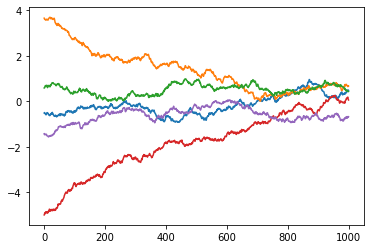

In [18]:
for i in range(5):
    OU_simulated_path = np.zeros(n_steps)
    
    OU_simulated_path[0]=np.random.uniform(-5,5)

    #OU_simulated_path[0]=np.random.normal(mu, stationary_std)
    
    for j in range(n_steps-1):  
        OU_simulated_path[j + 1] = OU_simulated_path[j] + (mu - OU_simulated_path[j]) * theta * dt + sigma * np.sqrt(dt) * np.random.randn()          
    
    plt.plot(OU_simulated_path)

In [19]:
dataset_indices, dataset_OU = generate_OU_dataset()

In [20]:
#the dataset paths only contain K=100 points
dataset_OU.shape

(2000, 100, 1)

In [21]:
dataset_indices.shape

(2000, 100, 1)

In [22]:
dataset_OU = np.transpose(dataset_OU, (0, 2, 1))
dataset_OU.shape

(2000, 1, 100)

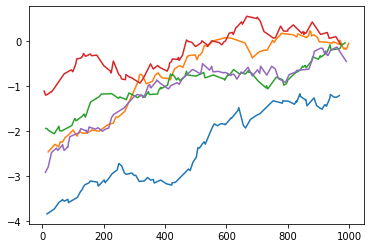

In [23]:
#these plots don't correspond to a whole OU path with 1000 points - they only contain K points
for i in range(5):
    plt.plot(dataset_indices[i,:,0],dataset_OU[i,0,:])
plt.show()

In [1]:
#rho(dt)=exp(-theta*dt), h=dt, 2h = 2dt, ....
def theoretical_acf_v1(theta):
    
    acf_theo=np.zeros(200)
    
    for h in range(200):
        #acf_theo[h]=np.exp(h*dt*np.log(abs(-theta*dt)))
        acf_theo[h]=np.exp(-theta*dt*h)
    
    return acf_theo

In [24]:
acf_theo_series_v1=theoretical_acf_v1(theta)
#plt.stem(acf_theo_series_v1, use_line_collection=True)

In [25]:
dt

0.001

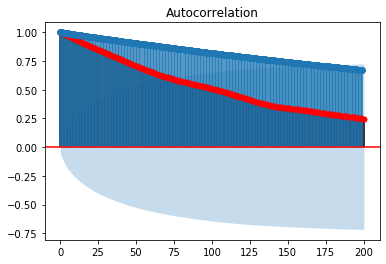

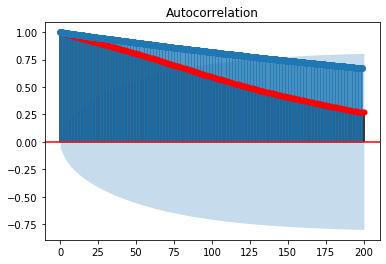

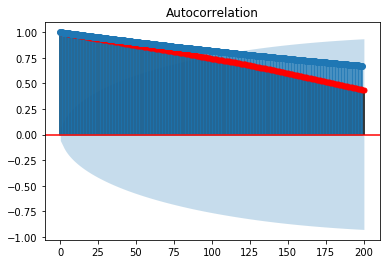

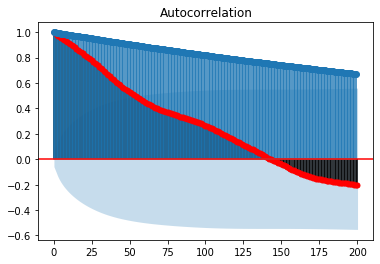

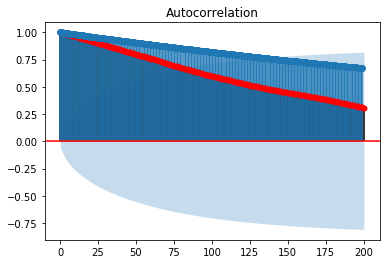

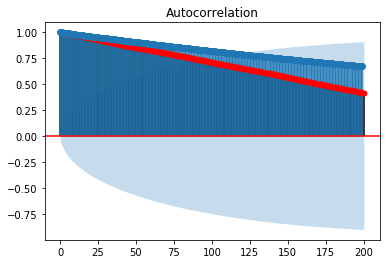

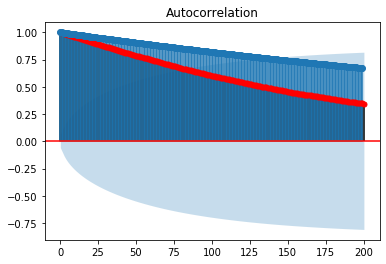

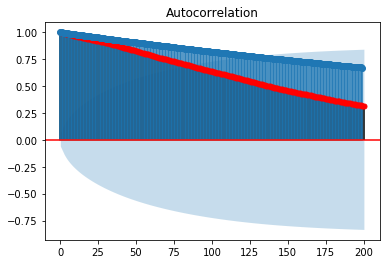

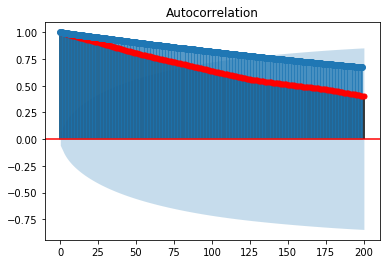

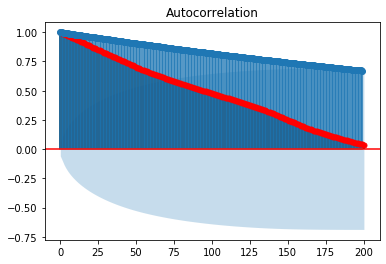

In [27]:
OU_paths=np.zeros([10,1000])
for i in range(10):
    OU_simulated_path = np.zeros(n_steps)
    
    OU_simulated_path[0]=np.random.uniform(-5,5)

    #OU_simulated_path[0]=np.random.normal(mu, stationary_std)
    
    for j in range(n_steps-1):  
        OU_simulated_path[j + 1] = OU_simulated_path[j] + (mu - OU_simulated_path[j]) * theta * dt + sigma * np.sqrt(dt) * np.random.randn()          
    
    OU_paths[i,:]=OU_simulated_path
    #print(OU_simulated_path.shape)
    #print(OU_paths.shape)
    #plt.plot(OU_simulated_path)
    
    OU_paths[i,:]=OU_simulated_path
    plot_acf(OU_paths[i,:], lags=200, color='r')
    plt.stem(acf_theo_series_v1, use_line_collection=True)
plt.show()

In [28]:
#convert the dataset indices into float
dataset_indices = np.array(dataset_indices, dtype=float)
dataset_indices.dtype

dtype('float64')

In [29]:
#convert all the indices to float
indices_float=np.array(indices, dtype=float)
#indices_float

In [30]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
             
        self.phi_rbf_centers =nn.Parameter(torch.tensor(
            np.random.choice(indices_float,num_phi_rbf)).unsqueeze(1))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-0.1, 0.1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)

  

    def Phi(self, input):
        input_expand = torch.unsqueeze(input, 1)
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)
        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = torch.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5

    def encoder(self, input):
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
  
    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
       
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x):        
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))        
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())        
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

   
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2), dim=1)        
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        
        return loss_term_3   

    
    def get_loss_Tresnia(self, fct_id, s, x, kl_factor):
        loss_term_1=self.get_loss_term_1(fct_id, s, x)        
        loss_term_2=self.get_loss_term_2(fct_id, s, x)        
        loss_term_3=self.get_loss_term_3(fct_id, kl_factor)
        
        return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, torch.mean(loss_term_1), \
        torch.mean(loss_term_2), loss_term_3
    
    def get_loss_Andrew(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)
        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2
     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_OU_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)
        beta_hat = self.decoder(z)
        x_dec = torch.matmul(phi_s, beta_hat)
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat

    
    def eval_at_z(self, z, s, return_beta_hat=False):     
        phi_s = self.Phi(s)
        beta_hat = self.decoder(z)
        x_dec = torch.matmul(phi_s, beta_hat)
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat


    # This function returns decoded values of OU process when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_OU_samples_from_pivae(self, s, num_samples):        
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()       
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

     # draw samples from the pivae
    def draw_samples_Andrew(self, s, num_samples):
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()       
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec
                   
    
    # Compute a quantity proportional to p(z|x, s) where x and s are new test points
    def get_unnormalized_log_posterior(self, s, x, z):        
        
        #z ~ N(0,1)
        log_prior = -0.5 * torch.sum(z**2)

        phi_s = self.Phi(s)
        #print("shape of phi_s", phi_s.shape)
        
        beta_hat = self.decoder(z)
        #print("shape of beta_hat", beta_hat.shape)
        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        #print("shape of x_dec", x_dec.shape)        
        
        x=torch.squeeze(x)
        #print("shape of x:", x.shape)
        
        #HOW DO WE OBTAIN THIS LIKELIHOOD FUNCTION? GAUSSIAN LL 
        log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

        return log_prior + torch.sum(log_likelihoods)
    
    def get_unnormalized_log_posterior_Andrew(self, s, x, z):

        log_prior = -0.5 * torch.sum(z**2)

        phi_s = self.Phi(s)
        beta_hat = self.decoder(z)
        x_dec = torch.matmul(phi_s, beta_hat)
        log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

        return log_prior + torch.sum(log_likelihoods)

In [31]:
def plot_decoded_OU_samples_from_z_posterior(model, z_samples_from_post, s_star, x_star):    
    test_indices = torch.arange(0, 1000, 1).double()        
    
    for i in range(z_samples_from_post.shape[0]):
        decoded_x = model.evaluate_decoded_OU_at_given_z(z_samples_from_post[i,:], test_indices.unsqueeze(1))

        plt.plot(test_indices.detach().numpy(), decoded_x.detach().numpy(), alpha=0.1, color='black')
    
    plt.scatter(s_star.detach().numpy(), x_star.detach().numpy(), s=1000, marker="+")
    plt.show()
    
    
def plot_posterior_samples_Andrew(model, samples, s_star, x_star):
    
    test_points = torch.arange(0, 1000, 1).double()
    
    for i in range(samples.shape[0]):
        
        func = model.eval_at_z(samples[i,:], test_points.unsqueeze(1))
        
        plt.plot(test_points.detach().cpu().numpy(),func.detach().cpu().numpy(), alpha=0.1, color='black')
        
    plt.scatter(s_star.detach().cpu().numpy(), x_star.detach().cpu().numpy(), s=1000, marker="+")
    plt.show()

In [32]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=10, bias=True)
  (phi_nn_2): Linear(in_features=10, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=32, bias=True)
  (decoder_nn_1): Linear(in_features=16, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [33]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 2000
#current_max = 1000
#interval = 2
nbr_epochs=100

In [34]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [35]:
#train for nbr_epochs
Avg_L_1s_all_epochs=np.zeros(shape=(nbr_epochs,0))
Avg_L_2s_all_epochs=np.zeros(shape=(nbr_epochs,0))
Avg_L_3s_all_epochs=np.zeros(shape=(nbr_epochs,0))
Avg_Total_Losses_all_epochs=np.zeros(shape=(nbr_epochs,0))

In [36]:
#training:

for epoch_id in range(nbr_epochs):
    print("Epoch Number:", epoch_id)
    
    #create empty containers for the losses L_1, L_2 and L_3:
    L_1s = []
    L_2s = []
    L_3s = []
    Total_Losses=[]    
    
    #for fct_id in range(num_funcs_to_consider):
    for fct_id in range(8):
        
        optimizer.zero_grad()
        
        input_points = torch.tensor(dataset_indices[fct_id])
        x_vals = torch.tensor(dataset_OU[fct_id])
        
        Total_Loss, L_1, L_2, L_3= pivae_model.get_loss_Andrew(fct_id, input_points, x_vals, kl_factor,print_breakdown=False,return_breakdown=True)        
        Total_Loss.backward()
        optimizer.step()
       
        L_1s.append(L_1.detach().numpy())        
        L_2s.append(L_2.detach().numpy())
        L_3s.append(L_3.detach().numpy())
        Total_Losses.append(Total_Loss.detach().numpy())
   
    Avg_L_1s_by_epoch=np.mean(np.array(L_1s))
    Avg_L_2s_by_epoch=np.mean(np.array(L_2s))
    Avg_L_3s_by_epoch=np.mean(np.array(L_3s))
    Avg_Total_Losses_by_epoch=np.mean(np.array(Total_Losses))
 

    Avg_L_1s_all_epochs=np.append(Avg_L_1s_all_epochs, Avg_L_1s_by_epoch)
    Avg_L_2s_all_epochs=np.append(Avg_L_2s_all_epochs, Avg_L_2s_by_epoch)
    Avg_L_3s_all_epochs=np.append(Avg_L_3s_all_epochs, Avg_L_3s_by_epoch)
    Avg_Total_Losses_all_epochs=np.append(Avg_Total_Losses_all_epochs, Avg_Total_Losses_by_epoch)
 
 
    #if epoch_id % interval == 0:
        #num_funcs_to_consider = min(num_funcs_to_consider+1, current_max)
   
    
    print("Total Loss: ", np.mean(np.array(Total_Losses)),
        "Loss 1: ", np.mean(np.array(L_1s)),
        "Loss 2: ", np.mean(np.array(L_2s)),
        "Loss 3: ", np.mean(np.array(L_3s)),
        "Number of functions considered in training: ", num_funcs_to_consider)

    

Epoch Number: 0
Total Loss:  4.648319584006811 Loss 1:  2.304474339811959 Loss 2:  2.3423388718892655 Loss 3:  0.001506372305586174 Number of functions considered in training:  2000
Epoch Number: 1
Total Loss:  2.8375965899796047 Loss 1:  1.223938782479551 Loss 2:  1.4834340829084418 Loss 3:  0.13022372459161227 Number of functions considered in training:  2000
Epoch Number: 2
Total Loss:  1.7053303113997476 Loss 1:  0.6967806467318083 Loss 2:  0.8636721974992819 Loss 3:  0.14487746716865751 Number of functions considered in training:  2000
Epoch Number: 3
Total Loss:  1.4454619116194434 Loss 1:  0.597948887921236 Loss 2:  0.708266582705052 Loss 3:  0.13924644099315497 Number of functions considered in training:  2000
Epoch Number: 4
Total Loss:  1.328162897016742 Loss 1:  0.5445253741115341 Loss 2:  0.6499362631270801 Loss 3:  0.13370125977812788 Number of functions considered in training:  2000
Epoch Number: 5
Total Loss:  1.2755725682109893 Loss 1:  0.5313322689383275 Loss 2:  0.616

Total Loss:  0.7433791773784522 Loss 1:  0.25966945761494425 Loss 2:  0.35931513876107657 Loss 3:  0.12439458100243127 Number of functions considered in training:  2000
Epoch Number: 46
Total Loss:  0.7469964423643173 Loss 1:  0.25614345139010986 Loss 2:  0.3618535640291271 Loss 3:  0.12899942694508035 Number of functions considered in training:  2000
Epoch Number: 47
Total Loss:  0.7352715086815674 Loss 1:  0.2534831061889054 Loss 2:  0.357344014379325 Loss 3:  0.12444438811333697 Number of functions considered in training:  2000
Epoch Number: 48
Total Loss:  0.7333599733950197 Loss 1:  0.25238487336783555 Loss 2:  0.354690110741712 Loss 3:  0.12628498928547208 Number of functions considered in training:  2000
Epoch Number: 49
Total Loss:  0.7313104345452875 Loss 1:  0.2492196843586245 Loss 2:  0.3549560371107484 Loss 3:  0.12713471307591467 Number of functions considered in training:  2000
Epoch Number: 50
Total Loss:  0.7272127150121714 Loss 1:  0.24697353548646384 Loss 2:  0.353543

Total Loss:  0.6220403609458097 Loss 1:  0.18808405071865358 Loss 2:  0.308658037511011 Loss 3:  0.12529827271614521 Number of functions considered in training:  2000
Epoch Number: 91
Total Loss:  0.6227541267807649 Loss 1:  0.19042782167059907 Loss 2:  0.305846483062214 Loss 3:  0.12647982204795188 Number of functions considered in training:  2000
Epoch Number: 92
Total Loss:  0.6243474138299964 Loss 1:  0.1881524618633264 Loss 2:  0.30606386651596124 Loss 3:  0.13013108545070867 Number of functions considered in training:  2000
Epoch Number: 93
Total Loss:  0.6194111520683382 Loss 1:  0.18652375528006004 Loss 2:  0.30540124554828607 Loss 3:  0.1274861512399921 Number of functions considered in training:  2000
Epoch Number: 94
Total Loss:  0.6221966048215912 Loss 1:  0.188022401192061 Loss 2:  0.3061154483539083 Loss 3:  0.12805875527562194 Number of functions considered in training:  2000
Epoch Number: 95
Total Loss:  0.6143986456096678 Loss 1:  0.18477896999804458 Loss 2:  0.3032171

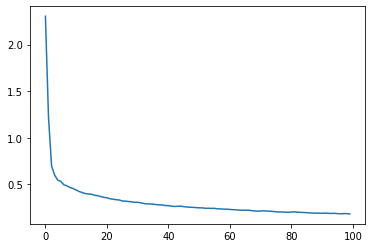

In [37]:
plt.plot(Avg_L_1s_all_epochs)
plt.show()

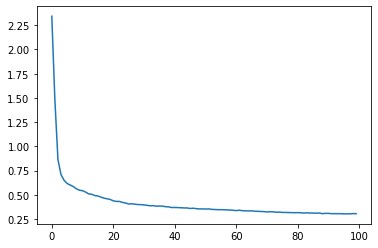

In [38]:
plt.plot(Avg_L_2s_all_epochs)
plt.show()

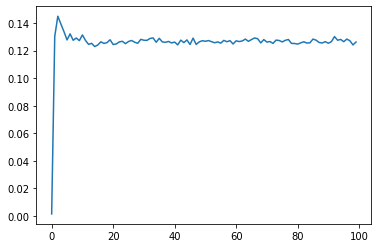

In [39]:
plt.plot(Avg_L_3s_all_epochs)
plt.show()

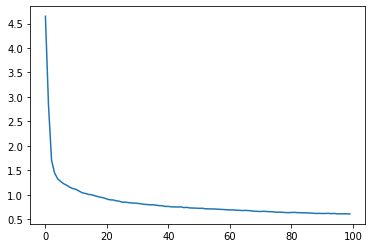

In [40]:
plt.plot(Avg_Total_Losses_all_epochs)
plt.show()

### Generate samples from piVAE using $z \sim N(0,1):$

In [41]:
locations_np=np.arange(0,1000, 10)
locations_tensor=torch.tensor(locations_np)
locations_tensor=locations_tensor.unsqueeze(1)
locations=locations_tensor.double()
locations_tensor.shape

torch.Size([100, 1])

In [42]:
num_samples=5
samples=pivae_model.generate_OU_samples_from_pivae(locations, num_samples)

In [43]:
samples = samples.detach().cpu().numpy()
locations = locations.detach().cpu().numpy()

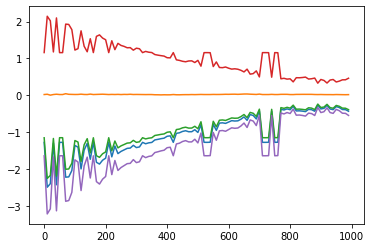

In [44]:
for i in range(samples.shape[0]):
    plt.plot(locations, samples[i, :])
plt.show()

In [45]:
theta

2.0

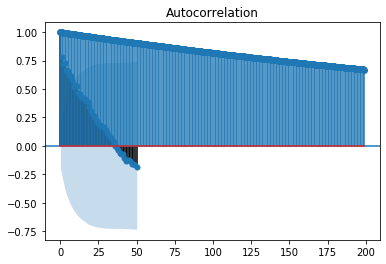

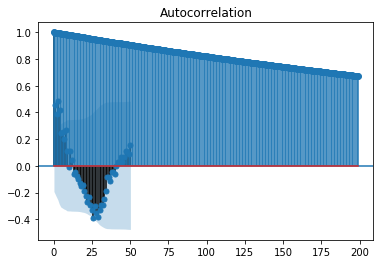

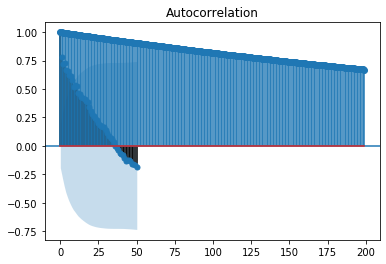

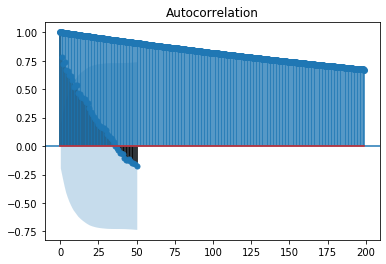

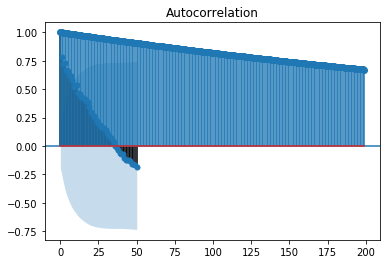

In [46]:
#plot the acf of some piVAE samples
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
for i in range(5):
    series=samples[i,:]
    plot_acf(series, lags=50)
    acf_theo_series_v1=theoretical_acf_v1(theta)
    plt.stem(acf_theo_series_v1, use_line_collection=True)

In [47]:
#if we change learning parameters does that change anything?
#instead of plotting the samples, plot the acf function of the piVAE samples 
#and see if it corresponds to the acf of an OU process

In [48]:
#Conditionally on s_star and x_star values, MH algo to accept or reject the new value of z
class MCMC():
    #we need to initialise our pivae model 
    def __init__(self, in_model):
        self.model = in_model
    
    #this function outputs sampled z values according to a Metropolis-Hastings algo
    def draw_MCMC_z_samples(self, nbr_z_samples, z_starting_point, MH_proposal_sigma, s_star, x_star):
        
        z = z_starting_point
        
        #create a tensor of zeros to contain the z values that are going to be sampled
        z_samples = torch.zeros((nbr_z_samples, z_dim)).double()
        
        acceptance_prob_sum = 0
        
        for z_sample in range(nbr_z_samples):
            z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2
            
            log_posterior_z = self.model.get_unnormalized_log_posterior(s_star, x_star, z)
            
            log_posterior_z_proposed = self.model.get_unnormalized_log_posterior(s_star, x_star, z_proposed)
            
            MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)
            
            acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)
            
            u = torch.rand(1).double()
            
            if u < acceptance_prob:
                z = z_proposed
            
            z_samples[z_sample, :] = z
            
            acceptance_prob_sum += acceptance_prob.detach()
            
        print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
        return z_samples
    
    
    

    
    def draw_MCMC_samples_Andrew(self, num_samples, starting_point, proposal_sigma, s_star, x_star):
        
        z = starting_point
        
        samples = torch.zeros((num_samples, z_dim)).double()
        
        acc_prob_sum = 0
        for t in range(num_samples):
            z_p = z + torch.randn_like(z) * proposal_sigma**2
            log_p_z = self.model.get_unnormalized_log_posterior(s_star, x_star, z)
            log_p_z_p = self.model.get_unnormalized_log_posterior(s_star, x_star, z_p)
            ratio = torch.exp(log_p_z_p - log_p_z)
            acc_prob = torch.min(torch.tensor(1.0).double(), ratio)
            u = torch.rand(1)
            if u < acc_prob:
                z = z_p
            samples[t, :] = z
            acc_prob_sum += acc_prob.detach().cpu().data
        print("mean acc prob", acc_prob_sum/num_samples)
        return samples


### Define a 'ground truth OU path' from which we select star points and then use MCMC for inference

In [49]:
sigma = 1.0
mu = 0.0  
theta = 2.0  

#stationary_std=sigma/(np.sqrt(2*theta))
#stationary_std

/Users/tresniaberah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if sys.path[0] == '':


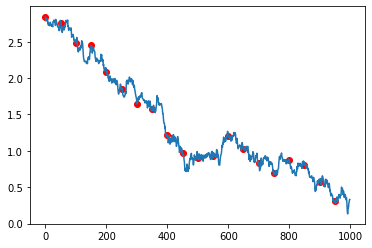

In [50]:
OU_whole_path_ground_truth = np.zeros(n_steps)

#OU_whole_path_ground_truth[0]=np.random.normal(mu, stationary_std)  

OU_whole_path_ground_truth[0]=np.random.uniform(-5,5)
                           
for i in range(n_steps-1):
    OU_whole_path_ground_truth[i + 1] = OU_whole_path_ground_truth[i] + (mu - OU_whole_path_ground_truth[i]) * theta*dt + sigma * np.sqrt(dt) * np.random.randn()
            
indices_star_20_np=np.arange(0,1000,50)

indices_star_20_np=np.expand_dims(indices_star_20_np,2)
indices_star_20_tensor=torch.tensor(indices_star_20_np)

OU_star_20_np=np.zeros(20)

for i in range(20):
    OU_star_20_np[i]=OU_whole_path_ground_truth[indices_star_20_np[i]]


plt.scatter(indices_star_20_np, OU_star_20_np, color='r')

plt.plot(OU_whole_path_ground_truth)

In [51]:
mcmc_fct = MCMC(pivae_model)

In [52]:
#we want the tensor of indices to be of shape (1,20,1)
indices_star_20_np=np.arange(0,1000,50)
indices_star_20_tensor=torch.tensor(indices_star_20_np)
indices_star_20_tensor=indices_star_20_tensor.unsqueeze(1)
#indices_star_20_tensor=indices_star_20_tensor.unsqueeze(0)
indices_star_20_tensor.shape

torch.Size([20, 1])

In [53]:
input_expand = torch.unsqueeze(indices_star_20_tensor, 1)
input_expand.shape

torch.Size([20, 1, 1])

In [54]:
#we want the tensor of x_values to be of shape (1,1,20)
OU_star_20_tensor=torch.tensor(OU_star_20_np)
OU_star_20_tensor=OU_star_20_tensor.unsqueeze(0)
OU_star_20_tensor=OU_star_20_tensor.unsqueeze(0)
OU_star_20_tensor.shape

torch.Size([1, 1, 20])

In [55]:
z = torch.randn((z_dim,)).double()

In [56]:
mcmc_samples_20 = mcmc_fct.draw_MCMC_z_samples(10000, z, 0.1, indices_star_20_tensor, OU_star_20_tensor)

mean acceptance prob tensor(0.1918, dtype=torch.float64)


In [57]:
mcmc_samples_20 = mcmc_samples_20[5000::100,:]

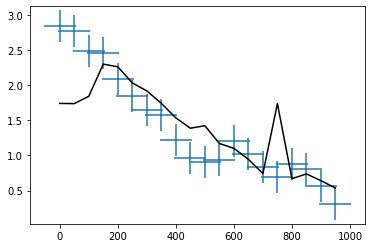

In [58]:
test_indices_points = torch.arange(0, 1000, 50).double()    
    
for i in range(mcmc_samples_20.shape[0]):   
    decoded_x = pivae_model.evaluate_decoded_OU_at_given_z(mcmc_samples_20[i,:], test_indices_points.unsqueeze(1))

plt.plot(test_indices_points.detach().numpy(), decoded_x.detach().numpy(), color='black')

    
plt.scatter(indices_star_20_np, OU_star_20_np, s=1000, marker="+")
plt.show()
    
    

In [59]:
#dataset_Andrew_sin_s, dataset_Andrew_sin_x
def check_beta(model, id):
    
    test_points = torch.arange(0, 1000, 10).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_indices[id].reshape(K), dataset_OU[id].reshape(K))
    plt.show()

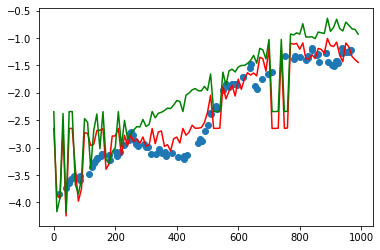

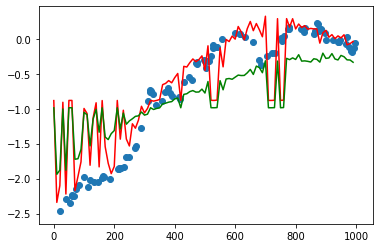

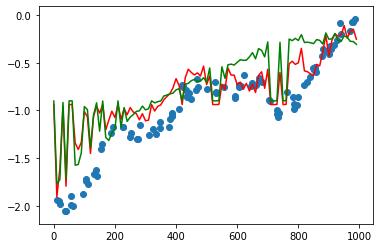

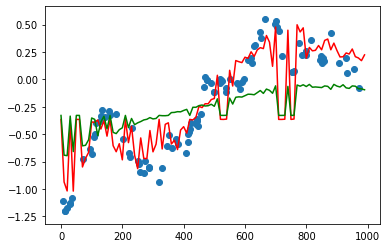

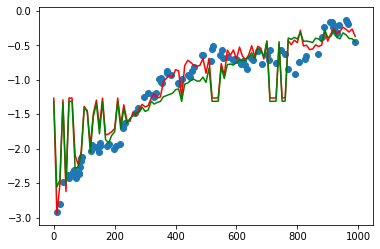

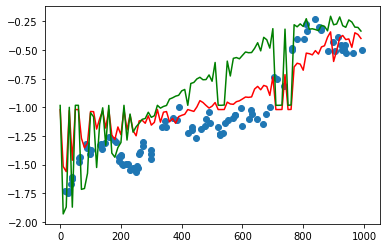

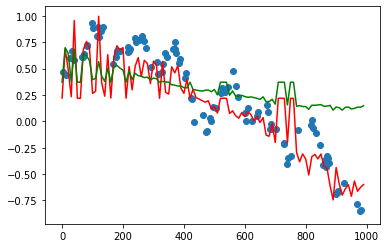

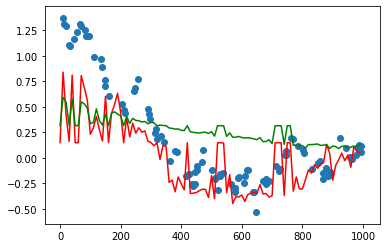

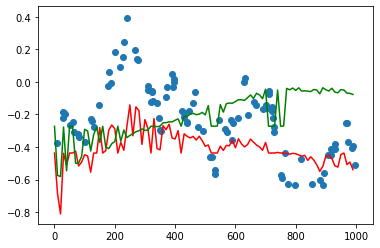

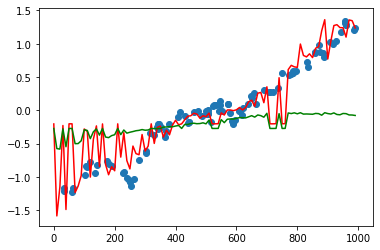

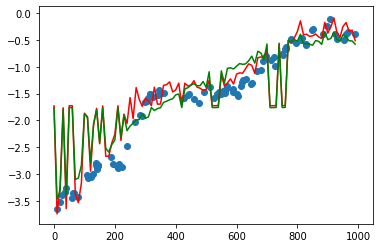

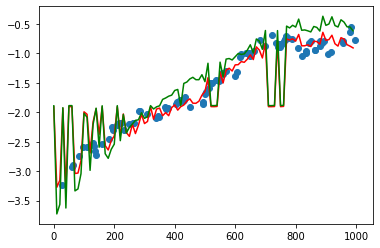

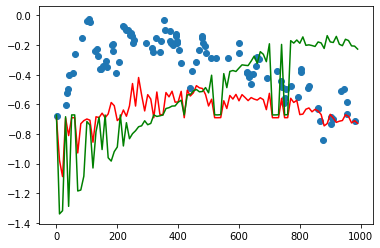

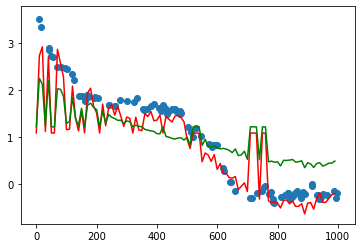

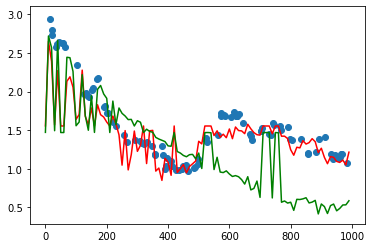

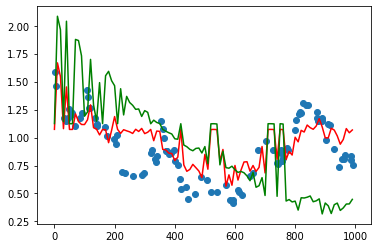

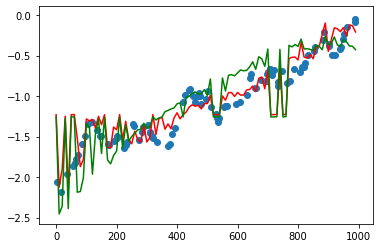

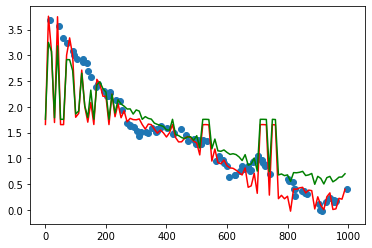

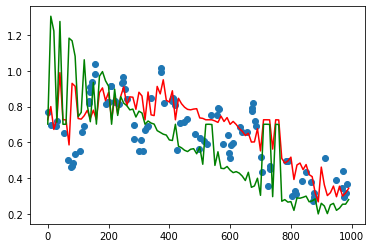

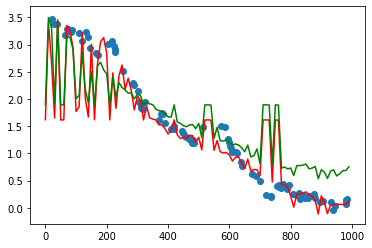

In [60]:
# ------ Check reconstructions of training data -------
for i in range(20):
    check_beta(pivae_model, i)
#%%

In [61]:
indices_star_5_np=np.array([0,250,500,750, 990])
indices_star_5_np

array([  0, 250, 500, 750, 990])

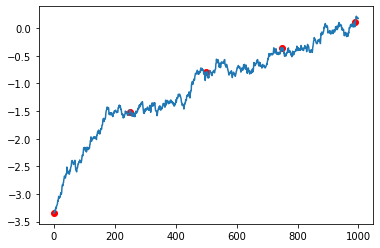

In [62]:
theta = 2.0  
sigma = 1.0
mu = 0.0  


OU_whole_path_ground_truth = np.zeros(n_steps)
OU_whole_path_ground_truth[0]=np.random.uniform(-5,5)
#OU_whole_path_ground_truth[0]=np.random.normal(mu, stationary_std)
        

for i in range(n_steps-1):
    OU_whole_path_ground_truth[i + 1] = OU_whole_path_ground_truth[i] + (mu - OU_whole_path_ground_truth[i]) * theta*dt + sigma * np.sqrt(dt) * np.random.randn()
            
indices_star_5_np=np.array([0,250,500,750,990])

#indices_star_5_np=np.expand_dims(indices_star_5_np,2)
indices_star_5_tensor=torch.tensor(indices_star_5_np)

#np.expand_dims(times_append_np,2), np.expand_dims(indices_append_np,2), np.expand_dims(OU_np,2)

OU_star_5_np=np.zeros(5)


for i in range(5):
    OU_star_5_np[i]=OU_whole_path_ground_truth[indices_star_5_np[i]]


plt.scatter(indices_star_5_np,OU_star_5_np, color='r')

plt.plot(OU_whole_path_ground_truth)

In [63]:
mcmc_fct = MCMC(pivae_model)

In [64]:
#we want the tensor of indices to be of shape (1,3,1)
indices_star_5_tensor=torch.tensor(indices_star_5_np)
indices_star_5_tensor=indices_star_5_tensor.unsqueeze(1)
#indices_star_5_tensor=indices_star_5_tensor.unsqueeze(0)
indices_star_5_tensor.shape

torch.Size([5, 1])

In [65]:
#we want the tensor of x_values to be of shape (1,1,3)
OU_star_5_tensor=torch.tensor(OU_star_5_np)
OU_star_5_tensor=OU_star_5_tensor.unsqueeze(0)
OU_star_5_tensor=OU_star_5_tensor.unsqueeze(0)
OU_star_5_tensor.shape

torch.Size([1, 1, 5])

In [66]:
z = torch.randn((z_dim,)).double()

In [67]:
mcmc_samples_5 = mcmc_fct.draw_MCMC_z_samples(10000, z, 0.1, indices_star_5_tensor, OU_star_5_tensor)

mean acceptance prob tensor(0.4578, dtype=torch.float64)


In [68]:
mcmc_samples_5 = mcmc_samples_5[1000::100,:]

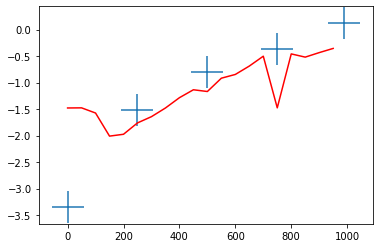

In [70]:
test_indices_points = torch.arange(0, 1000, 50).double()    
    
for i in range(mcmc_samples_5.shape[0]):   
    decoded_x = pivae_model.evaluate_decoded_OU_at_given_z(mcmc_samples_5[i,:], test_indices_points.unsqueeze(1))

plt.plot(test_indices_points.detach().numpy(), decoded_x.detach().numpy(), color='red')

    
plt.scatter(indices_star_5_np, OU_star_5_np, s=1000, marker="+")
plt.show()
    